# CIFAR-10 Dataset: A Computer Vision Benchmark

Prediction


In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [4]:
image_dir = "datasets/test"

In [5]:
def load_image(id):
    image_path = os.path.join(image_dir, f"{id}.png")
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    return image

In [6]:
test_ids = np.arange(1, 300001)

In [7]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_ids)
test_dataset = test_dataset.map(lambda id: tf.py_function(load_image, [id], [tf.float32]), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
test_dataset = test_dataset.map(lambda x: (tf.ensure_shape(x, [32, 32, 3])),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
def configure_performance(ds, is_train_ds=True):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [13]:
test_dataset = configure_performance(test_dataset, is_train_ds=False)

In [15]:
image_batch = next(iter(test_dataset))

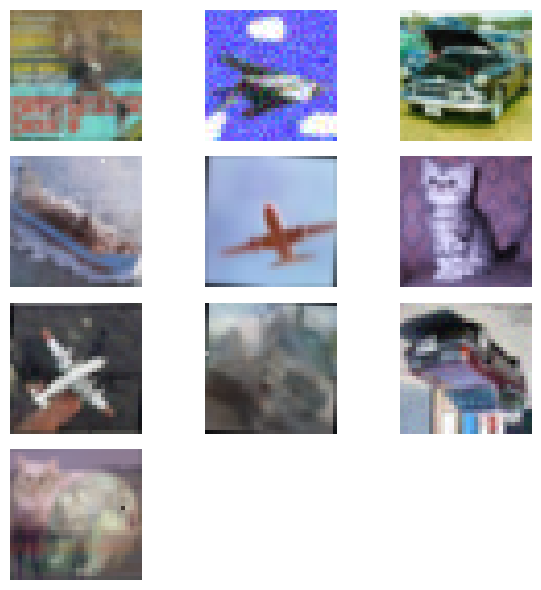

In [17]:
plt.figure(figsize=(6, 6))

for i in range(10):
  ax = plt.subplot(4, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.axis("off")

plt.tight_layout()


# Load Model

In [30]:
object_mapping = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}


In [24]:
model = tf.keras.models.load_model("mlp_model")

In [25]:
predictions = model.predict(test_dataset)

9375/9375 [==============================] - 1160s 124ms/step


In [26]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.int32)

In [28]:
submission = pd.DataFrame(np.arange(1, 300001), columns=["id"])
submission["label"] = predicted_labels.numpy()

In [29]:
submission.head()

,id,label
0,1,2
1,2,0
2,3,7
3,4,8
4,5,0


In [32]:
submission.replace({"label": object_mapping}, inplace=True)

In [33]:
submission.to_csv("submission.csv", index=False)

In [35]:
submission.head()

,id,label
0,1,bird
1,2,airplane
2,3,horse
3,4,ship
4,5,airplane


In [19]:
sample_submission = pd.read_csv("datasets/sampleSubmission.csv")

In [20]:
sample_submission.head()

,id,label
0,1,cat
1,2,cat
2,3,cat
3,4,cat
4,5,cat
